In [70]:
import os
os.chdir('C:\\Users\\davia\\Downloads\\AIMLCA1\\CA1\\Dataset')

In [71]:
import pandas as pd
df = pd.read_csv('CA1-Regression-Dataset.csv')

In [72]:
# Import pandas that allows us to view and manipulate data
import numpy as np
import pandas as pd

# Import datasets(s), and function that allows us to do train-test split
from sklearn.model_selection import train_test_split

# Import visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Import warnings and ignore if warnings are shown
import warnings
warnings.filterwarnings('ignore')

### 1. Data pre-processing

In [73]:
# Finding out the types of data in each column
df.dtypes

ID            int64
Age           int64
Gender       object
BMI         float64
Smoker       object
Region       object
Cost ($)    float64
dtype: object

In [74]:
df

,ID,Age,Gender,BMI,Smoker,Region,Cost ($)
0,1,19,female,27.900,yes,southwest,16884.92400
1,2,18,male,33.770,no,southeast,1725.55230
2,3,28,male,33.000,no,southeast,4449.46200
3,4,33,male,22.705,no,northwest,21984.47061
4,5,32,male,28.880,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,1334,50,male,30.970,no,northwest,10600.54830
1334,1335,18,female,31.920,no,northeast,2205.98080
1335,1336,18,female,36.850,no,southeast,1629.83350
1336,1337,21,female,25.800,no,southwest,2007.94500


#### 1.1 One Hot Encoding

There are a few columns that need to be converted into dummy variables like Gender, Smoker, and Region

In [76]:
df_dummies = pd.get_dummies(df[['Gender', 'Smoker', 'Region']], drop_first=True, dtype='int')
df = pd.concat([df,df_dummies], axis=1)
df = df.drop(['Gender', 'Smoker', 'Region'], axis=1)
df.head()

,ID,Age,BMI,Cost ($),Gender_male,Smoker_yes,Region_northwest,Region_southeast,Region_southwest
0,1,19,27.900,16884.92400,0,1,0,0,1
1,2,18,33.770,1725.55230,1,0,0,1,0
2,3,28,33.000,4449.46200,1,0,0,1,0
3,4,33,22.705,21984.47061,1,0,1,0,0
4,5,32,28.880,3866.85520,1,0,1,0,0


In [77]:
# Finding out the types of data in each column
df.dtypes

ID                    int64
Age                   int64
BMI                 float64
Cost ($)            float64
Gender_male           int32
Smoker_yes            int32
Region_northwest      int32
Region_southeast      int32
Region_southwest      int32
dtype: object

#### 1.2 Check For Outliers

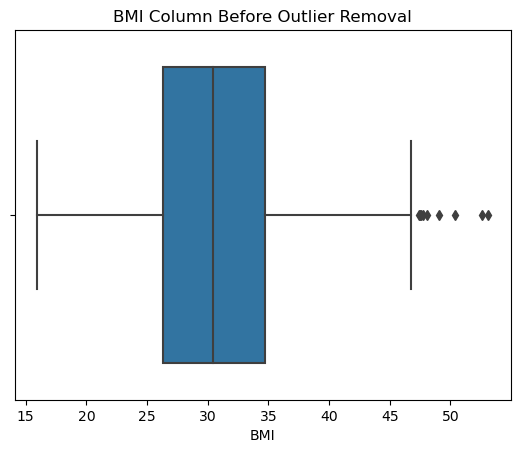

In [78]:
sns.boxplot(x=df['BMI'])
plt.title("BMI Column Before Outlier Removal")
plt.show()

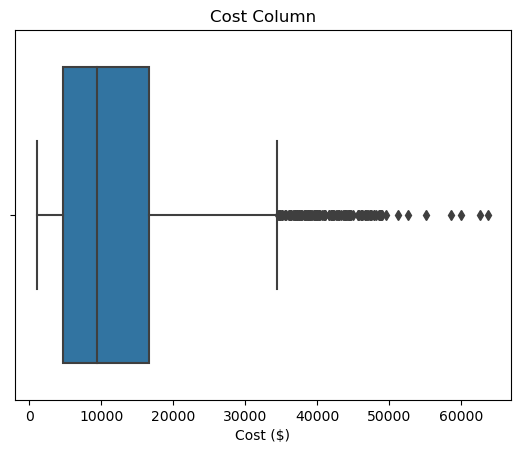

In [79]:
sns.boxplot(x=df['Cost ($)'])
plt.title("Cost Column")
plt.show()

As I cannot be 100% certain that the outliers are unreasonable, I have decided agaisnt removing the outliers

#### 1.3 Data Imputation

<Axes: >

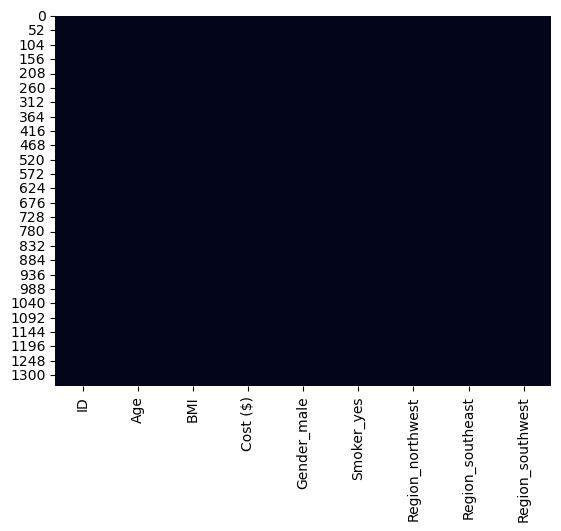

In [80]:
# Print out a heatmap to show how much missing data there is in the dataset
sns.heatmap(df.isnull(), cbar=False)

In [81]:
df.isnull().sum()

ID                  0
Age                 0
BMI                 0
Cost ($)            0
Gender_male         0
Smoker_yes          0
Region_northwest    0
Region_southeast    0
Region_southwest    0
dtype: int64

As there are no missing data, we will not need to impute anything

### 1.4 Train Test Split

I will be using 2 approaches to this. The first approach will be to use lasso to tell us which features are important while the second approach is me choosing which features are important. 

I will then train the models on both sets of data and cross validate them and choose the best set of data

In [82]:
X = df.drop(['Cost ($)', 'ID'], axis=1)
y = df['Cost ($)']

ID is being dropped as I am 100% confident that it is unrelated to cost

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 1.4.1 Data Scaling

In [84]:
# Import Standard Scaler to scale data
from sklearn.preprocessing import StandardScaler

In [85]:
X_train[['Age', 'BMI']].describe()

,Age,BMI
count,1070.000000,1070.000000
mean,39.357009,30.560397
std,14.073960,6.043386
min,18.000000,15.960000
25%,27.000000,26.205000
50%,39.500000,30.210000
75%,51.000000,34.496250
max,64.000000,53.130000


In [86]:
X_test.head()

,Age,BMI,Gender_male,Smoker_yes,Region_northwest,Region_southeast,Region_southwest
764,45,25.175,0,0,0,0,0
887,36,30.020,0,0,1,0,0
890,64,26.885,0,1,1,0,0
1293,46,25.745,1,0,1,0,0
259,19,31.920,1,1,1,0,0


In [87]:
scaler = StandardScaler()

X_train[['Age', 'BMI']] = scaler.fit_transform(X_train[['Age', 'BMI']])
X_test[['Age', 'BMI']] = scaler.transform(X_test[['Age', 'BMI']])

X_test.head()

,Age,BMI,Gender_male,Smoker_yes,Region_northwest,Region_southeast,Region_southwest
764,0.401140,-0.891539,0,0,0,0,0
887,-0.238638,-0.089461,0,0,1,0,0
890,1.751782,-0.608453,0,1,1,0,0
1293,0.472227,-0.797177,1,0,1,0,0
259,-1.447107,0.225079,1,1,1,0,0


#### 1.4.1 Choosing Features Using Lasso

In [88]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [89]:
# Define a range of alpha values to test (can range from 0 to infinity, but problem if 0 is used)
alphas = np.arange(1,110, 0.1)

In [90]:
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42)
lasso_cv.fit(X_train, y_train)
y_pred_lasso = lasso_cv.predict(X_test)
mse_lasso = mean_squared_error(y_test,  y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Lasso CV - Best Alpha: {lasso_cv.alpha_}, MSE: {mse_lasso}, R2: {r2_lasso}")
print(f"Intercept: {lasso_cv.intercept_}")
print(f"Coefficients: {lasso_cv.coef_}")

Lasso CV - Best Alpha: 77.70000000000007, MSE: 34658812.107251115, R2: 0.7767530093533315
Intercept: 8592.216217166102
Coefficients: [ 3569.92680376  1903.18254947     0.         23186.88868089
     0.            -0.           -54.81380399]


In [91]:
X_train.columns

Index(['Age', 'BMI', 'Gender_male', 'Smoker_yes', 'Region_northwest',
       'Region_southeast', 'Region_southwest'],
      dtype='object')

In [92]:
X_train_lasso = X_train.copy()[['Age', 'BMI', 'Smoker_yes']]
X_test_lasso = X_test.copy()[['Age', 'BMI', 'Smoker_yes']]

The Lasso Regressor has chosen Age, BMI and whether a person smokes to be the best indicators of Cost

#### 1.4.2 Choosing Features Based On What I Think Is Important

As for me, I think that all columns are needed

### 2. Tuning The Models Hyperparameters

In [93]:
# Importing cross_val_score for k-fold validation
from sklearn.model_selection import cross_val_score, KFold

# Importing GridSerachCV and RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#### 2.1 Lasso Regression

In [94]:
# Define a range of alpha values to test (can range from 0 to infinity, but problem if 0 is used)
alphas = np.arange(1,110, 0.1)

#### 2.1.1 Lasso Regression With Lasso Features

In [95]:
lasso_model_lasso = LassoCV(alphas=alphas, cv=5)
lasso_model_lasso.fit(X_train_lasso, y_train)

LassoCV(alphas=array([  1. ,   1.1,   1.2, ..., 109.7, 109.8, 109.9]), cv=5)

#### 2.1.2 Lasso Regression With My Features

In [96]:
lasso_model = LassoCV(alphas=alphas, cv=5)
lasso_model.fit(X_train, y_train)

LassoCV(alphas=array([  1. ,   1.1,   1.2, ..., 109.7, 109.8, 109.9]), cv=5)

#### 2.2 Ridge Regression

In [97]:
from sklearn.linear_model import RidgeCV

# Define a range of alpha values to test (can range from 0 to infinity, but problem if 0 is used)
alphas = np.arange(1,110, 0.1)

#### 2.2.1 Ridge Regression With Lasso Features

In [98]:
ridge_model_lasso = RidgeCV(alphas=alphas, cv=5, scoring='r2')
ridge_model_lasso.fit(X_train_lasso, y_train)
ridge_y_pred_lasso = ridge_model_lasso.predict(X_test_lasso)

#### 2.2.2 Ridge Regression With My Features

In [99]:
ridge_model = RidgeCV(alphas=alphas, cv=5, scoring='r2')
ridge_model.fit(X_train, y_train)
ridge_y_pred = ridge_model.predict(X_test)

#### 2.3 Linear Regression

In [100]:
from sklearn.linear_model import LinearRegression

# Get the params in LinearRegression
LinearRegression().get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [101]:
params = {"fit_intercept": [True, False], "positive": [True, False]}

#### 2.3.1 Linear Regression With Lasso Features

In [102]:
linear_regression_model_lasso = GridSearchCV(LinearRegression(), param_grid=params, cv=5, n_jobs=-1, scoring='r2')
linear_regression_model_lasso.fit(X_train_lasso, y_train)

print("Tuned Linear Regression Parameters: {}".format(linear_regression_model_lasso.best_params_))
print("Tuned Linear Regression Best R2 Score: {}".format(linear_regression_model_lasso.best_score_))

Tuned Linear Regression Parameters: {'fit_intercept': True, 'positive': False}
Tuned Linear Regression Best R2 Score: 0.7331372786803418


#### 2.3.2 Linear Regression With My Features

In [103]:
linear_regression_model = GridSearchCV(LinearRegression(), param_grid=params, cv=5, n_jobs=-1, scoring='r2')
linear_regression_model.fit(X_train, y_train)

print("Tuned Linear Regression Parameters: {}".format(linear_regression_model.best_params_))
print("Tuned Linear Regression Best R2 Score: {}".format(linear_regression_model.best_score_))

Tuned Linear Regression Parameters: {'fit_intercept': True, 'positive': True}
Tuned Linear Regression Best R2 Score: 0.732525891024525


#### 2.4 Bayesian Ridge Regression

In [104]:
from sklearn.linear_model import BayesianRidge

# Get the params in BayesianRidge
BayesianRidge().get_params()

{'alpha_1': 1e-06,
 'alpha_2': 1e-06,
 'alpha_init': None,
 'compute_score': False,
 'copy_X': True,
 'fit_intercept': True,
 'lambda_1': 1e-06,
 'lambda_2': 1e-06,
 'lambda_init': None,
 'max_iter': None,
 'n_iter': 'deprecated',
 'tol': 0.001,
 'verbose': False}

In [105]:
param_grid = {
    'n_iter': [100, 200, 300, 400],
    'alpha_1': [1e-4, 1e-5, 1e-6, 1e-7, 1e-8],
    'alpha_2': [1e-4, 1e-5, 1e-6, 1e-7, 1e-8],
    'lambda_1': [1e-4, 1e-5, 1e-6, 1e-7, 1e-8],
    'lambda_2': [1e-4, 1e-5, 1e-6, 1e-7, 1e-8],
}

#### 2.4.1 Bayesian Ridge With Lasso Features

In [106]:
bayesian_ridge_model_lasso = GridSearchCV(BayesianRidge(), param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')
bayesian_ridge_model_lasso.fit(X_train_lasso, y_train)

print("Tuned Bayesian Ridge Parameters: {}".format(bayesian_ridge_model_lasso.best_params_))
print("Tuned Bayesian Ridge Best R2 Score: {}".format(bayesian_ridge_model_lasso.best_score_))

Tuned Bayesian Ridge Parameters: {'alpha_1': 1e-08, 'alpha_2': 0.0001, 'lambda_1': 0.0001, 'lambda_2': 1e-06, 'n_iter': 100}
Tuned Bayesian Ridge Best R2 Score: 0.733140079919503


#### 2.4.2 Bayesian Ridge With My Features

In [107]:
bayesian_ridge_model = GridSearchCV(BayesianRidge(), param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')
bayesian_ridge_model.fit(X_train, y_train)

print("Tuned Bayesian Ridge Parameters: {}".format(bayesian_ridge_model.best_params_))
print("Tuned Bayesian Ridge Best R2 Score: {}".format(bayesian_ridge_model.best_score_))

Tuned Bayesian Ridge Parameters: {'alpha_1': 1e-08, 'alpha_2': 0.0001, 'lambda_1': 0.0001, 'lambda_2': 0.0001, 'n_iter': 100}
Tuned Bayesian Ridge Best R2 Score: 0.7314290934617287


#### 2.5 Decision Tree Regressor Model

In [108]:
from sklearn.tree import DecisionTreeRegressor

# Get the params in DecisionTreeRegressor
DecisionTreeRegressor().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [109]:
param_grid = {
    'max_depth': np.concatenate((np.arange(0,12,1), [None])),
    'min_samples_split': np.arange(0,8,1),
    'min_samples_leaf': np.arange(0,12,1)
}

#### 2.5.1 Decision Tree Regressor With Lasso Features

In [110]:
decision_tree_model_lasso = GridSearchCV(DecisionTreeRegressor(), param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')
decision_tree_model_lasso.fit(X_train_lasso, y_train)

print("Tuned Decision Tree Regressor Parameters: {}".format(decision_tree_model_lasso.best_params_))
print("Tuned Decision Tree Regressor Best R2 Score: {}".format(decision_tree_model_lasso.best_score_))

Tuned Decision Tree Regressor Parameters: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Tuned Decision Tree Regressor Best R2 Score: 0.8417172960750039


#### 2.5.2 Decision Tree Regressor With My Features

In [111]:
decision_tree_model = GridSearchCV(DecisionTreeRegressor(), param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')
decision_tree_model.fit(X_train, y_train)

print("Tuned Decision Tree Regressor Parameters: {}".format(decision_tree_model.best_params_))
print("Tuned Decision Tree Regressor Best R2 Score: {}".format(decision_tree_model.best_score_))

Tuned Decision Tree Regressor Parameters: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Tuned Decision Tree Regressor Best R2 Score: 0.8414193488922151


#### 2.6 SVR Model

In [112]:
from sklearn.svm import SVR

# Get the params in DecisionTreeRegressor
SVR().get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [113]:
param_grid = {
    'C': np.linspace(0.01, 5, 100),
    'gamma': np.linspace(0.01, 1, 200)
}

#### 2.6.1 SVR With Lasso Features

In [114]:
svr_model_lasso = RandomizedSearchCV(SVR(), param_distributions=param_grid, cv=5, n_jobs=-1, scoring='r2', n_iter=100)
svr_model_lasso.fit(X_train_lasso, y_train)

print("Tuned Support Vector Regressor Parameters: {}".format(svr_model_lasso.best_params_))
print("Tuned Support Vector Regressor Best R2 Score: {}".format(svr_model_lasso.best_score_))

Tuned Support Vector Regressor Parameters: {'gamma': 0.5323618090452261, 'C': 5.0}
Tuned Support Vector Regressor Best R2 Score: -0.08618355459216528


#### 2.6.2 SVR With My Features

In [115]:
svr_model = RandomizedSearchCV(SVR(), param_distributions=param_grid, cv=5, n_jobs=-1, scoring='r2', n_iter=100)
svr_model.fit(X_train, y_train)

print("Tuned Support Vector Regressor Parameters: {}".format(svr_model.best_params_))
print("Tuned Support Vector Regressor Best R2 Score: {}".format(svr_model.best_score_))

Tuned Support Vector Regressor Parameters: {'gamma': 0.23386934673366835, 'C': 4.9495959595959595}
Tuned Support Vector Regressor Best R2 Score: -0.09210796214272192


#### 2.7 Dummy Regressor Model

In [116]:
# Import the DummyRegressor
from sklearn.dummy import DummyRegressor

DummyRegressor().get_params()

{'constant': None, 'quantile': None, 'strategy': 'mean'}

In [117]:
param_grid = {
    'strategy': ['mean', 'median', 'quantile', 'constant']
}

#### 2.7.1 Dummy Regressor With Lasso Features

In [118]:
dummy_model_lasso = GridSearchCV(DummyRegressor(), param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')
dummy_model_lasso.fit(X_train_lasso, y_train)

print("Tuned Dummy Regressor Parameters: {}".format(dummy_model_lasso.best_params_))
print("Tuned Dummy Regressor Regressor Best R2 Score: {}".format(dummy_model_lasso.best_score_))

Tuned Dummy Regressor Parameters: {'strategy': 'mean'}
Tuned Dummy Regressor Regressor Best R2 Score: -0.004796192893767958


#### 2.7.2 Dummy Regressor With My Features

In [119]:
dummy_model = GridSearchCV(DummyRegressor(), param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')
dummy_model.fit(X_train, y_train)

print("Tuned Dummy Regressor Parameters: {}".format(dummy_model.best_params_))
print("Tuned Dummy Regressor Regressor Best R2 Score: {}".format(dummy_model.best_score_))

Tuned Dummy Regressor Parameters: {'strategy': 'mean'}
Tuned Dummy Regressor Regressor Best R2 Score: -0.004796192893767958


### 3. K-Fold Validation For Models

#### 3.1 Lasso Regression

In [120]:
lasso_model_lasso_r2 = cross_val_score(lasso_model_lasso, X_train_lasso, y_train, cv = 5, scoring='r2', n_jobs=-1, verbose=3)
lasso_model_lasso_mae = cross_val_score(lasso_model_lasso, X_train_lasso, y_train, cv = 5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=3)*-1
lasso_model_lasso_mse = cross_val_score(lasso_model_lasso, X_train_lasso, y_train, cv = 5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)*-1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


In [121]:
lasso_model_r2 = cross_val_score(lasso_model, X_train, y_train, cv = 5, scoring='r2', n_jobs=-1, verbose=3)
lasso_model_mae = cross_val_score(lasso_model, X_train, y_train, cv = 5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=3)*-1
lasso_model_mse = cross_val_score(lasso_model, X_train, y_train, cv = 5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)*-1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


#### 3.2 Ridge Regression

In [122]:
ridge_model_lasso_r2 = cross_val_score(ridge_model_lasso, X_train_lasso, y_train, cv = 5, scoring='r2', n_jobs=-1, verbose=3)
ridge_model_lasso_mae = cross_val_score(ridge_model_lasso, X_train_lasso, y_train, cv = 5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=3)*-1
ridge_model_lasso_mse = cross_val_score(ridge_model_lasso, X_train_lasso, y_train, cv = 5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)*-1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.3s remaining:   18.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.4s remaining:   17.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.4s remaining:   17.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.6s finished


In [123]:
ridge_model_r2 = cross_val_score(ridge_model, X_train, y_train, cv = 5, scoring='r2', n_jobs=-1, verbose=3)
ridge_model_mae = cross_val_score(ridge_model, X_train, y_train, cv = 5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=3)*-1
ridge_model_mse = cross_val_score(ridge_model, X_train, y_train, cv = 5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)*-1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.7s remaining:   19.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.5s remaining:   18.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.4s remaining:   18.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.5s finished


#### 3.3 Linear Regression

In [124]:
linear_regression_model_lasso_r2 = cross_val_score(linear_regression_model_lasso, X_train_lasso, y_train, cv = 5, scoring='r2', n_jobs=-1, verbose=3)
linear_regression_model_lasso_mae = cross_val_score(linear_regression_model_lasso, X_train_lasso, y_train, cv = 5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=3)*-1
linear_regression_model_lasso_mse = cross_val_score(linear_regression_model_lasso, X_train_lasso, y_train, cv = 5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)*-1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [125]:
linear_regression_model_r2 = cross_val_score(linear_regression_model, X_train, y_train, cv = 5, scoring='r2', n_jobs=-1, verbose=3)
linear_regression_model_mae = cross_val_score(linear_regression_model, X_train, y_train, cv = 5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=3)*-1
linear_regression_model_mse = cross_val_score(linear_regression_model, X_train, y_train, cv = 5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)*-1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


#### 3.4 Bayesian Ridge Regression

In [126]:
bayesian_ridge_model_lasso_r2 = cross_val_score(bayesian_ridge_model_lasso, X_train_lasso, y_train, cv = 5, scoring='r2', n_jobs=-1, verbose=3)
bayesian_ridge_model_lasso_mae = cross_val_score(bayesian_ridge_model_lasso, X_train_lasso, y_train, cv = 5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=3)*-1
bayesian_ridge_model_lasso_mse = cross_val_score(bayesian_ridge_model_lasso, X_train_lasso, y_train, cv = 5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)*-1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   50.0s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   50.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   49.8s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   50.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   49.8s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   50.1s finished


In [127]:
bayesian_ridge_model_r2 = cross_val_score(bayesian_ridge_model, X_train, y_train, cv = 5, scoring='r2', n_jobs=-1, verbose=3)
bayesian_ridge_model_mae = cross_val_score(bayesian_ridge_model, X_train, y_train, cv = 5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=3)*-1
bayesian_ridge_model_mse = cross_val_score(bayesian_ridge_model, X_train, y_train, cv = 5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)*-1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   56.2s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   56.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   55.1s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   54.8s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.4s finished


#### 3.5 Decision Tree Regressor Model

In [128]:
decision_tree_model_lasso_r2 = cross_val_score(decision_tree_model_lasso, X_train_lasso, y_train, cv = 5, scoring='r2', n_jobs=-1, verbose=3)
decision_tree_model_lasso_mae = cross_val_score(decision_tree_model_lasso, X_train_lasso, y_train, cv = 5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=3)*-1
decision_tree_model_lasso_mse = cross_val_score(decision_tree_model_lasso, X_train_lasso, y_train, cv = 5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)*-1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   15.3s remaining:   23.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   15.0s remaining:   22.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   15.0s remaining:   22.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.1s finished


In [129]:
decision_tree_model_r2 = cross_val_score(decision_tree_model, X_train, y_train, cv = 5, scoring='r2', n_jobs=-1, verbose=3)
decision_tree_model_mae = cross_val_score(decision_tree_model, X_train, y_train, cv = 5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=3)*-1
decision_tree_model_mse = cross_val_score(decision_tree_model, X_train, y_train, cv = 5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)*-1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   16.8s remaining:   25.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   16.9s remaining:   25.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   16.8s remaining:   25.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.9s finished


#### 3.6 SVR Model

In [130]:
svr_model_lasso_r2 = cross_val_score(svr_model_lasso, X_train_lasso, y_train, cv = 5, scoring='r2', n_jobs=-1, verbose=3)
svr_model_lasso_mae = cross_val_score(svr_model_lasso, X_train_lasso, y_train, cv = 5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=3)*-1
svr_model_lasso_mse = cross_val_score(svr_model_lasso, X_train_lasso, y_train, cv = 5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)*-1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.4s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.4s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.3s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.6s finished


In [131]:
svr_model_r2 = cross_val_score(svr_model, X_train, y_train, cv = 5, scoring='r2', n_jobs=-1, verbose=3)
svr_model_mae = cross_val_score(svr_model, X_train, y_train, cv = 5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=3)*-1
svr_model_mse = cross_val_score(svr_model, X_train, y_train, cv = 5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)*-1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.6s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.5s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.6s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.6s finished


#### 3.7 Dummy Regressor Model

In [132]:
dummy_model_lasso_r2 = cross_val_score(dummy_model_lasso, X_train_lasso, y_train, cv = 5, scoring='r2', n_jobs=-1, verbose=3)
dummy_model_lasso_mae = cross_val_score(dummy_model_lasso, X_train_lasso, y_train, cv = 5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=3)*-1
dummy_model_lasso_mse = cross_val_score(dummy_model_lasso, X_train_lasso, y_train, cv = 5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)*-1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [133]:
dummy_model_r2 = cross_val_score(dummy_model, X_train, y_train, cv = 5, scoring='r2', n_jobs=-1, verbose=3)
dummy_model_mae = cross_val_score(dummy_model, X_train, y_train, cv = 5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=3)*-1
dummy_model_mse = cross_val_score(dummy_model, X_train, y_train, cv = 5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)*-1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


### 4. Choose The Best Model

#### 4.1 Model Evaluation For Lasso Features

In [134]:
models_lasso_scores = pd.DataFrame(
    {
        "R2": [round(np.mean(lasso_model_lasso_r2), 4), round(np.mean(ridge_model_lasso_r2), 4), round(np.mean(linear_regression_model_lasso_r2), 4), round(np.mean(bayesian_ridge_model_lasso_r2), 4), round(np.mean(decision_tree_model_lasso_r2), 4), round(np.mean(svr_model_lasso_r2), 4), round(np.mean(dummy_model_lasso_r2), 4)],
        "MAE": [round(np.mean(lasso_model_lasso_mae), 4), round(np.mean(ridge_model_lasso_mae), 4), round(np.mean(linear_regression_model_lasso_mae), 4), round(np.mean(bayesian_ridge_model_lasso_mae), 4), round(np.mean(decision_tree_model_lasso_mae), 4), round(np.mean(svr_model_lasso_mae), 4), round(np.mean(dummy_model_lasso_mae), 4)],
        "MSE": [round(np.mean(lasso_model_lasso_mse), 4), round(np.mean(ridge_model_lasso_mse), 4), round(np.mean(linear_regression_model_lasso_mse), 4), round(np.mean(bayesian_ridge_model_lasso_mse), 4), round(np.mean(decision_tree_model_lasso_mse), 4), round(np.mean(svr_model_lasso_mse), 4), round(np.mean(dummy_model_lasso_mse), 4)]
    },
    index=["lasso_model_lasso", "ridge_model_lasso", "linear_regression_model_lasso", "bayesian_ridge_model_lasso", "decision_tree_model_lasso", "svr_model_lasso", "dummy_model_lasso"]
)
models_lasso_scores

,R2,MAE,MSE
lasso_model_lasso,0.7331,4257.8106,3.794295e+07
ridge_model_lasso,0.7331,4271.7176,3.795229e+07
linear_regression_model_lasso,0.7331,4255.9036,3.793803e+07
bayesian_ridge_model_lasso,0.7331,4258.1738,3.793821e+07
decision_tree_model_lasso,0.8417,2769.4253,2.244196e+07
svr_model_lasso,-0.0863,8052.1454,1.565509e+08
dummy_model_lasso,-0.0048,9004.2100,1.445975e+08


#### 4.1 Model Evaluation For My Features

In [135]:
models_scores = pd.DataFrame(
    {
        "R2": [round(np.mean(lasso_model_r2), 4), round(np.mean(ridge_model_r2), 4), round(np.mean(linear_regression_model_r2), 4), round(np.mean(bayesian_ridge_model_r2), 4), round(np.mean(decision_tree_model_r2), 4), round(np.mean(svr_model_r2), 4), round(np.mean(dummy_model_r2), 4)],
        "MAE": [round(np.mean(lasso_model_mae), 4), round(np.mean(ridge_model_mae), 4), round(np.mean(linear_regression_model_mae), 4), round(np.mean(bayesian_ridge_model_mae), 4), round(np.mean(decision_tree_model_mae), 4), round(np.mean(svr_model_mae), 4), round(np.mean(dummy_model_mae), 4)],
        "MSE": [round(np.mean(lasso_model_mse), 4), round(np.mean(ridge_model_mse), 4), round(np.mean(linear_regression_model_mse), 4), round(np.mean(bayesian_ridge_model_mse), 4), round(np.mean(decision_tree_model_mse), 4), round(np.mean(svr_model_mse), 4), round(np.mean(dummy_model_mse), 4)]
    },
    index=["lasso_model", "ridge_model", "linear_regression_model", "bayesian_ridge_model", "decision_tree_model", "svr_model", "dummy_model"]
)
models_scores

,R2,MAE,MSE
lasso_model,0.7324,4276.1214,3.805228e+07
ridge_model,0.7313,4290.7190,3.820581e+07
linear_regression_model,0.7324,4265.6688,3.804381e+07
bayesian_ridge_model,0.7314,4277.2276,3.818326e+07
decision_tree_model,0.8414,2788.7208,2.248344e+07
svr_model,-0.0922,8141.2635,1.574394e+08
dummy_model,-0.0048,9004.2100,1.445975e+08


### 5. Evaluating The Chosen Model

From the results shown above, the Decision Tree Regressor trained on the features chosen by LassoCV and scaled has the highest R2 score, lowest MAE and MSE score making it clear that it is the best model for this dataset.

We will now test the model on the test data to get our final result

In [141]:
y_pred = decision_tree_model_lasso.predict(X_test_lasso)

print(f"The model's R2 score: {round(r2_score(y_test, y_pred), 2)}")
print(f"The model's MAE score: {round(mean_absolute_error(y_test, y_pred), 2)}")
print(f"The model's MSE score: {round(mean_squared_error(y_test, y_pred), 2)}")

The model's R2 score: 0.86
The model's MAE score: 2718.43
The model's MSE score: 21433399.11


### 6. Conclusion

##### - How is your prediction task defined? And what is the meaning of the output variable?

    We are predicting the hospital cost in US hospitals based on various patient information, such as ID, Age, Gender, BMI, etc.

##### - Did you process the features in any way?

    The features underwent scaling only. There was no imputation nor removing of outlier as there is no missing data in the data set and I can't be 100% certain that the outliers are unreasonable

##### - How did you select which learning algorithms to use?

    The selection of learning algorithms were chosen based on what we learned in class and also by researching models to use for regression

##### - Did you try to tune the hyperparameters of the learning algorithm, and in that case how?

    I made sure to tune the hyperparameters of all models. I did that by first looking at what params each model has to offer and then search through the sklearn documentation and google to find out which parameters to tune

##### - How do you evaluate the quality of your system?

    I evaluated the quality of my system using 3 different scoring metrics namely r2, mse and mae. The reason behind comparing using multiple scoring metrics is to ensure that the model is generally better than the rest.

    I chose the model by making sure that at least 2 of its scoring metrics is the best when compared to other models

##### - How well does your system compare to a dummy baseline?

    My system compares dramatically better to the dummy baseline. To be specific, its r2 score is 17635.4% higher than the baseline, its MAE is 69.24% better than the baseline and its MSE is 84.48% better than the baseline.

##### - Is it possible to say something about which features the model considers important? (Whether this is possible depends on the type of classifier you are using)

    I can't say as to which features the Random Tree Regressor consideres important but the Lasso Regressor considered the Age, BMI and whether the person smokes to be important.

    In addition, the Random Tree Regressor performed better when only using the features reccomended by the Lasso Regressor. Therefore, you could say that the Random Tree Regressor considers those features to be important.